In [1]:
import pandas as pd
import numpy as np
import pickle
import argparse
import os
import random
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch

In [2]:
def reproducibility(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
reproducibility(3)

In [3]:
# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

Device set to : NVIDIA GeForce RTX 2080 Ti


# Arguments

In [4]:

def args_create():
    # @title Arguments
    parser = argparse.ArgumentParser(description='Actor Critic')


    # Environment Setup
    parser.add_argument('--data', default="/mnt/kerem/CEU", type=str, help='Dataset Path')
    parser.add_argument('--episodes', default=100000, type=int, metavar='N', help='Number of episodes for training agent.')
    parser.add_argument('--seed', default=3, type=int, help='Seed for reproducibility')
    parser.add_argument('--a_control_size', default=50, type=int, help='Attack Control group size')
    parser.add_argument('--b_control_size', default=50, type=int, help='Beacon Control group size')
    parser.add_argument('--gene_size', default=100000, type=int, help='States gene size')
    parser.add_argument('--beacon_size', default=10, type=int, help='Beacon population size')
    parser.add_argument('--victim_prob', default=1, type=float, help='Victim inside beacon or not!')
    parser.add_argument('--max_queries', default=50, type=int, help='Maximum queries per episode')
    parser.add_argument('--evaluate', default=False, type=bool, help='Evaluation or Not')


    # Training Setup
    parser.add_argument('--train', default="attacker", choices=["attacker", "beacon", "both"], type=str, help='Train side!')
    
    parser.add_argument('--attacker_type', default="agent", choices=["random", "optimal", "agent"], type=str, help='Type of the attacker')
    parser.add_argument('--beacon_type', default="truth", choices=["random", "agent", "truth", "beacon_strategy"], type=str, help='Type of the beacon')

    parser.add_argument('--beacon_agent', default="td", choices=["td", "ppo"], type=str, help='Type of the beacon')

    parser.add_argument('--pop_reset_freq', default=100000000, type=int, help='Reset Population Frequency (Epochs)')
    parser.add_argument('--update_freq', default=10, type=int, help='Train Agent model frequency')
    parser.add_argument('--plot-freq', default=10, type=int, metavar='N', help='Plot Frequencies')
    parser.add_argument('--print-freq', default=10, type=int, metavar='N', help='Plot Frequencies')


    parser.add_argument('--resume-attacker', default=None, type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
    parser.add_argument('--resume-beacon', default=None, type=str, metavar='PATH', help='path to latest checkpoint (default: none)')


    parser.add_argument('--results-dir', default='./results/train', type=str, metavar='PATH', help='path to cache (default: none)')


    # args = parser.parse_args()  # running in command line
    args = parser.parse_args('')  # running in ipynb

    args.results_dir = os.path.join(args.results_dir, "run"+str(len(os.listdir(args.results_dir))))
    os.makedirs(args.results_dir)
    os.makedirs(args.results_dir+"/logs")
    os.makedirs(args.results_dir+"/rewards")
    os.makedirs(args.results_dir+"/indrewards")
    os.makedirs(args.results_dir+"/actions")
    os.makedirs(args.results_dir+"/pvalues")

    args.device = device

    print(args)
    return args



In [8]:
# CEU Beacon - it contains 164 people in total which we will divide into groups to experiment
beacon = pd.read_csv(os.path.join("/mnt/kerem/CEU", "Beacon_164.txt"), index_col=0, delim_whitespace=True)
# Reference genome, i.e. the genome that has no SNPs, all major allele pairs for each position
reference = pickle.load(open(os.path.join("/mnt/kerem/CEU", "reference.pickle"),"rb"))
# Binary representation of the beacon; 0: no SNP (i.e. no mutation) 1: SNP (i.e. mutation)
binary = np.logical_and(beacon.values != reference, beacon.values != "NN").astype(int)

In [5]:
import os
import joblib

# Cache file path
cache_path = "/data6/sobhan/Beacons/dataset/binary_cache.joblib"

# Check if the cached file exists
if os.path.exists(cache_path):
    print("Exists")
    # Load from cache
    binary = joblib.load(cache_path)
else:
    # If cache doesn't exist, process and save to cache
    beacon = pd.read_csv(os.path.join("/mnt/kerem/CEU", "Beacon_164.txt"), index_col=0, delim_whitespace=True)
    reference = pickle.load(open(os.path.join("/mnt/kerem/CEU", "reference.pickle"), "rb"))
    binary = np.logical_and(beacon.values != reference, beacon.values != "NN").astype(int)
    
    # Save the processed binary data to cache for future use
    joblib.dump(binary, cache_path)

Exists


# Read Data

In [6]:
# Table that contains MAF (minor allele frequency) values for each position. 
maf = pd.read_csv(os.path.join("/mnt/kerem/CEU", "MAF.txt"), index_col=0, delim_whitespace=True)
maf.rename(columns = {'referenceAllele':'major', 'referenceAlleleFrequency':'major_freq', 
                      'otherAllele':'minor', 'otherAlleleFrequency':'minor_freq'}, inplace = True)
maf["maf"] = np.round(maf["maf"].values, 3)
# Same variable with sorted maf values
sorted_maf = maf.sort_values(by='maf')
# Extracting column to an array for future use
maf_values = maf["maf"].values

binary = binary.T
binary.shape #(164, 4029840)

(164, 4029840)

# PPO

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
from env import Env
from ppo import PPO
from ddpg import DDPG
from td import TD3
from engine import train_beacon, train_attacker, train_both, train_TD_beacon

args = args_create()
def main():
    env = Env(args, maf_values, binary)
    
    if args.train == "beacon":
        ################ PPO hyperparameters ################
        if args.resume_attacker:
            attacker_agent = PPO(400, 10, lr_actor, lr_critic, gamma, K_epochs, eps_clip, False, None)
            attacker_agent.load(args.resume_attacker)


        if args.beacon_agent == "td":
            state_dim = 18
            action_dim = 1  
            beacon_agent = TD3(state_dim, action_dim, max_action=1)
            train_TD_beacon(args, env, beacon_agent)

        elif args.beacon_agent == "ppo":
            K_epochs = 300         # update policy for K epochs
            eps_clip = 0.2           # clip parameter for PPO
            gamma = 0.99                # discount factor

            lr_actor = 0.001       # learning rate for actor network
            lr_critic = 0.001        # learning rate for critic network

            beacon_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, False, None)
            train_beacon(args, env, beacon_agent)

        else:
            raise NotImplemented
            
            
    elif args.train == "attacker":
        attacker_state_dim = 10
        attacker_action_dim = 12

        ################ PPO hyperparameters ################
        K_epochs = 300         # update policy for K epochs
        eps_clip = 0.2           # clip parameter for PPO
        gamma = 0.99                # discount factor

        lr_actor = 0.001       # learning rate for actor network
        lr_critic = 0.001        # learning rate for critic network

        attacker_agent = PPO(attacker_state_dim, attacker_action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, False, None)
        train_attacker(args, env, attacker_agent)

    else:
        ################ PPO hyperparameters ################
        K_epochs = 300         # update policy for K epochs
        eps_clip = 0.2           # clip parameter for PPO
        gamma = 0.99                # discount factor

        lr_actor = 0.0001       # learning rate for actor network
        lr_critic = 0.0001        # learning rate for critic network

        action_std = 0.4

        state_dim = 9
        action_dim = 1

        attacker_state_dim = 400
        attacker_action_dim = 10

        # initialize a PPO agent
        # beacon_agent = DDPG(state_dim, action_dim, )
        beacon_agent = TD3(state_dim, action_dim, max_action=1)
        # beacon_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, False, None)
        attacker_agent = PPO(attacker_state_dim, attacker_action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, False, None)

        if args.resume_attacker:
            attacker_agent.load(args.resume_attacker)

        if args.resume_beacon:
            beacon_agent.load(args.resume_beacon)
            
        train_both(args, env, beacon_agent, attacker_agent)


if __name__ == '__main__':
    # with open(args.results_dir + '/output.txt', 'w') as sys.stdout:
    main()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Namespace(data='/mnt/kerem/CEU', episodes=100000, seed=3, a_control_size=50, b_control_size=50, gene_size=100000, beacon_size=10, victim_prob=1, max_queries=50, evaluate=False, train='attacker', attacker_type='agent', beacon_type='truth', beacon_agent='td', pop_reset_freq=100000000, update_freq=10, plot_freq=10, print_freq=10, resume_attacker=None, resume_beacon=None, results_dir='./results/train/run83', device=device(type='cuda', index=0))
./results/train/run83/logs/beacon_log.csv
./results/train/run83/logs/beacon_control_log.csv
./results/train/run83/logs/attacker_log.csv
./results/train/run83/logs/attacker_control_log.csv
==================================⬇️⬇️⬇️⬇️Episode: 1⬇️⬇️⬇️⬇️==============================
ATTACKER TYPE:  agent
BEACON TYPE:  random
-------------------------
Started training at (GMT) :  2024-10-20 18:03:01
--------------------------------Query: 1------------------------------

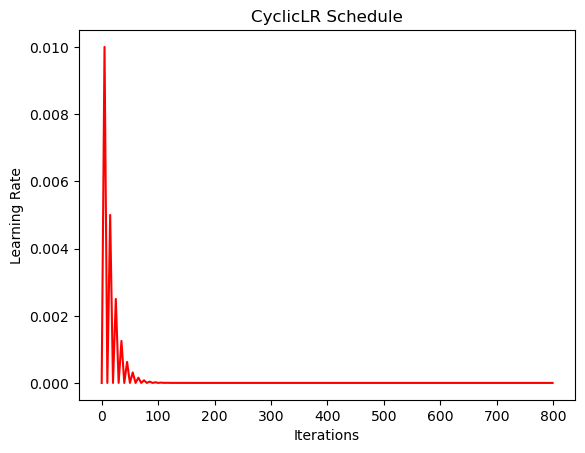

In [17]:
import torch
from matplotlib import pyplot as plt

lr_list = []
model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]

# Initial learning rate
LR = 0.001
optimizer = torch.optim.Adam(model, lr=LR)

# Define the CyclicLR scheduler
max_lr = 0.01
min_lr = 0.000001
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer, base_lr=0.00001, max_lr=0.01, 
    cycle_momentum=False, mode='triangular2', step_size_up=5, step_size_down=5
)

# Simulate training over multiple epochs
for epoch in range(1, 5):
    data_size = 200
    for i in range(data_size):
        optimizer.zero_grad()
        # Simulate a step (e.g., loss.backward() and optimizer.step())
        optimizer.step()
        
        # Record the current learning rate
        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        
        # Step the scheduler
        scheduler.step()

# Plot the learning rate schedule
plt.plot(range(len(lr_list)), lr_list, color='r')
plt.xlabel('Iterations')
plt.ylabel('Learning Rate')
plt.title('CyclicLR Schedule')
plt.show()


In [1]:
import torch
genome = torch.as_tensor(1)
maf =   torch.as_tensor(0.036)
response =  torch.as_tensor(0)


DN_i = (1 - maf).pow(2 * 20) 
DN_i_1 = (1 - maf).pow(2 * 20 - 2)

# Genome == 1
log1 = torch.log(DN_i) - torch.log(0.001 * DN_i_1)
log2 = torch.log((0.001 * DN_i_1 * (1 - DN_i))) - torch.log(DN_i * (1 - 0.001 * DN_i_1))

# Genome == 0
log3 = torch.log(DN_i) - torch.log((1 - 0.001) * DN_i_1)
log4 = torch.log((1 - 0.001) * DN_i_1 * (1 - DN_i)) - torch.log(DN_i * (1 - DN_i_1 * (1 - 0.001)))

x_hat_i = (genome * response) + ((1 - genome) * (1 - response))
lrt = (log1 + log2 * x_hat_i)* genome + (log3 + log4 * x_hat_i) * (1 - genome)
        # print("lrts, lrts.size()", lrts, lrts.size())
print(lrt)

tensor(6.8344)


In [5]:
from utils import lrt

genome = torch.as_tensor(1)
maf =   torch.as_tensor(0.036)
response =  torch.as_tensor(0.5)

lrt(20, genome, maf, response)

tensor(0.2307, dtype=torch.float64) tensor(0.2483, dtype=torch.float64)
tensor(6.8344, dtype=torch.float64) tensor(-7.0965, dtype=torch.float64)
tensor(1., dtype=torch.float64) tensor(0.0360, dtype=torch.float64) tensor(0.5000, dtype=torch.float64) tensor(3.2862, dtype=torch.float64)


tensor(3.2862, dtype=torch.float64)

/tmp/ipykernel_63210/3792215476.py:30: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [mpatches.Patch(color=color_palette[i], label=labels[i], edgecolor='black', alpha=0.8) for i in range(classes)]


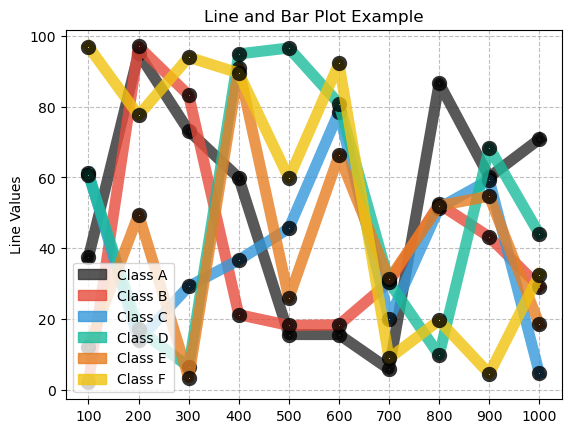

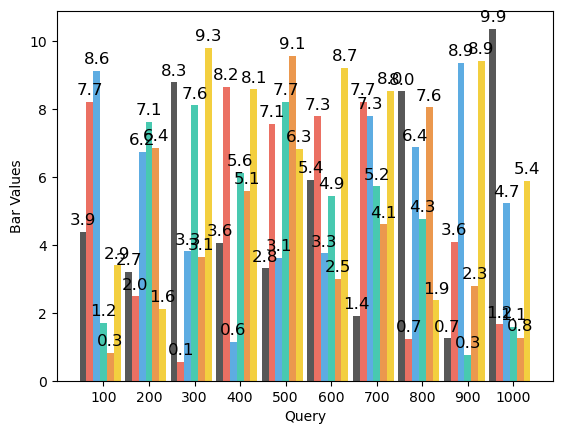

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def line_and_bar_plot_separate(line_data, bar_data, labels, title, ylabel_line, ylabel_bar):
    # First figure for line plot
    fig1, ax1 = plt.subplots()
    color_palette = ["#2E2E2E", "#E74C3C", "#3498DB", "#1ABC9C", "#E67E22", "#F1C40F"]
    x_ticks = ['100', '200', '300', '400', '500', '600', '700', '800', '900', '1000']
    classes, stages = line_data.shape
    x_positions = np.arange(stages)

    # Plotting the line data
    for class_idx in range(classes):
        class_data = line_data[class_idx, :]  # shape (stages,)
        edge_color = 'black'
        line_color = color_palette[class_idx]
        # Plotting the line with markers
        ax1.plot(x_positions, class_data, marker='o', color=line_color, markeredgewidth=5, markeredgecolor=edge_color, linewidth=8, alpha=0.8)

    ax1.set_ylabel(ylabel_line)
    ax1.set_title(title)
    
    # Set x-axis ticks and labels
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(x_ticks)
    ax1.grid(True, linestyle='--', color='gray', alpha=0.5)

    # Adding legend for line plot
    handles = [mpatches.Patch(color=color_palette[i], label=labels[i], edgecolor='black', alpha=0.8) for i in range(classes)]
    ax1.legend(handles, labels, loc="lower left")

    # Second figure for bar plot
    fig2, ax2 = plt.subplots()
    bar_width = 0.15  # Adjusted Bar width for better clarity

    # Plotting the bar data
    for class_idx in range(classes):
        bar_vals = bar_data[class_idx, :]  # shape (stages,)
        bar_color = color_palette[class_idx]
        
        # Offset the bar positions to avoid overlap
        bars = ax2.bar(x_positions + (class_idx - classes / 2) * bar_width, bar_vals + 0.5, width=bar_width, color=bar_color, alpha=0.8)
        
        # Annotate bars with their values
        for bar in bars:
            height = bar.get_height()
            ax2.annotate(f'{height-0.5:.1f}',  # format the label
                         xy=(bar.get_x() + bar.get_width() / 2, height),  # set the label position
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom',
                         fontsize=12)

    # Set ylabel for bar plot
    ax2.set_ylabel(ylabel_bar)
    ax2.set_xlabel('Query')
    
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels(x_ticks)

    plt.show()

# Random test data generation
np.random.seed(42)
line_data = np.random.rand(6, 10) * 100  # 6 classes, 10 stages
bar_data = np.random.rand(6, 10) * 10  # 6 classes, 10 stages
labels = ['Class A', 'Class B', 'Class C', 'Class D', 'Class E', 'Class F']

# Define parameters
title = "Line and Bar Plot Example"
ylabel_line = "Line Values"
ylabel_bar = "Bar Values"

# Call the function to plot the figures with random test data
line_and_bar_plot_separate(line_data, bar_data, labels, title, ylabel_line, ylabel_bar)